In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn import metricsplt.style.use('ggplot') # This styles the graphs in a nicer format

import statsmodels.formula.api as smf

In [218]:
UFC = pd.read_csv('Data/2a) UFC Fights.csv')

#make sure theres no space in the columns
UFC.columns = [c.replace(' ', '_') for c in UFC.columns]

#change outcome win = 1, everything else 0
UFC['OUTCOME1'] = UFC.OUTCOME.map({'win':1, 'loss':0, 'draw':0, 'NC':0})

#change stance and stance_diff into 1,0
#check out what stances there are
print UFC.STANCE.value_counts()
#lets just put orthodox as 1, other as 0
UFC['STANCE1'] = UFC.STANCE.map({'Orthodox':1, 'Southpaw':0, 'Switch':0, 'Open Stance':0,'Sideways':0})
#same stance = 0
UFC['STANCE_DIFF1'] = UFC.STANCE_DIFF.map({'Same Stance':0, 'Different Stance':1})

#Try using more stance information
# create a DataFrame with the four dummy variable columns
STANCE_dummies = pd.get_dummies(UFC.STANCE, prefix='STANCE').iloc[:, 1:]
#STANCE_dummies
UFC = pd.concat([UFC, STANCE_dummies], axis=1)

#Stance information works well, but it looksl ike southpaw is a great advantage. Group observations into southpaw = 1
#Other = 0
UFC['STANCE2'] = UFC.STANCE.map({'Orthodox':0, 'Southpaw':1, 'Switch':0, 'Open Stance':0,'Sideways':0})

#print column names and type
print UFC.dtypes
print UFC.shape

Orthodox       5338
Southpaw       1350
Switch          161
Open Stance      24
Sideways          5
Name: STANCE, dtype: int64
FIGHT_ORDER                 int64
KEY                        object
ROUND_FORMAT               object
EVENT_TYPE                 object
EVENT_NAME                 object
EVENT_YEAR                  int64
EVENT_MONTH                 int64
EVENT_DAY                   int64
LOCATION_COUNTRY           object
LOCATION_CITY              object
VENUE                      object
ATTENDANCE                float64
MAIN_FIGHT                 object
MID                         int64
WEIGHT_CLASS               object
REF                        object
METHOD                     object
METHOD_D                   object
ROUND                     float64
FINISH_ROUND_MIN          float64
FINISH_ROUND_SEC          float64
FINISH_ROUND_INSECONDS    float64
TOTAL_INSECONDS           float64
FIGHTER_NAME               object
FIGHER_NO                  object
OUTCOME                

In [219]:
#Add Business Filters
#Exclude fights where it is single round only
UFC1=UFC[(UFC.ROUND_FORMAT == 'MULTI-ROUND')]
#see how many fights are there for each weight class
print UFC1.WEIGHT_CLASS.value_counts()
#from initial investigation we will exclude Women's classes, Catch Weight and Super Heavyweight
UFC1=UFC[(UFC.ROUND_FORMAT == 'MULTI-ROUND')&(-UFC.WEIGHT_CLASS.isin(['Super Heavyweight','Catch Weight','Womens Bantamweight','Womens Strawweight']))&(UFC.WEIGHT_CLASS.notnull())]
print UFC1.WEIGHT_CLASS.value_counts()

Lightweight            1434
Welterweight           1400
Middleweight           1094
Light Heavyweight       726
Heavyweight             676
Featherweight           546
Bantamweight            434
Flyweight               212
Womens Bantamweight     110
Womens Strawweight       76
Catch Weight             28
Super Heavyweight         2
Name: WEIGHT_CLASS, dtype: int64
Lightweight          1434
Welterweight         1400
Middleweight         1094
Light Heavyweight     726
Heavyweight           676
Featherweight         546
Bantamweight          434
Flyweight             212
Name: WEIGHT_CLASS, dtype: int64


In [220]:
#check out missing values
#print UFC1.isnull().sum()

#we'll need to see if we want to fill the missing values or just exclude them
#Lets see how much data we exclude by class if we exclude all observations with any missing values
UFC1a = UFC1.dropna()
print UFC1.shape
print UFC1a.shape

#roughly we've dropped half the observations - let's check by weight class but first..
#check if nickname means anything, otherwise let's drop as it makes up most of the missing
UFC1.NICK.isnull().sum()
#print UFC1[(UFC1.NICK.isnull())&(UFC1.OUTCOME=='win')].shape
#print UFC1[(UFC1.NICK.notnull())&(UFC1.OUTCOME=='win')].shape
#seems irrelevant, I'm going to remove the column and exclude again to increase data points

UFC1b = UFC1.drop('NICK', 1)
UFC1b = UFC1b.dropna()
print UFC1.shape
print UFC1a.shape
print UFC1b.shape

#how much remaining by class?
print UFC1b.WEIGHT_CLASS.value_counts()

(6522, 68)
(3520, 68)
(6522, 68)
(3520, 68)
(4694, 67)
Lightweight          1074
Welterweight          975
Middleweight          748
Light Heavyweight     496
Featherweight         460
Heavyweight           411
Bantamweight          339
Flyweight             191
Name: WEIGHT_CLASS, dtype: int64


In [286]:
#CLASS='Flyweight','Bantamweight','Featherweight','Lightweight','Welterweight','Middleweight','Light Heavyweight','Heavyweight'

CLASS = 'Lightweight',

#All classes
#Weight class	Upper weight limit
#Flyweight	125 lb (56.7 kg; 8.9 st)
#Bantamweight	135 lb (61.2 kg; 9.6 st)
#Featherweight	145 lb (65.8 kg; 10.4 st)
#Lightweight	155 lb (70.3 kg; 11.1 st)
#Welterweight	170 lb (77.1 kg; 12.1 st)
#Middleweight	185 lb (83.9 kg; 13.2 st)
#Light Heavyweight	205 lb (93.0 kg; 14.6 st)
#Heavyweight	265 lb (120.2 kg; 18.9 st)

In [287]:
#lets now have a look at correlation matrix for each class - total one won't mean much 
#as fighters fight at different weight classes

#for each class, look at which variables correlate highest with outcome
#use this to build first gen model
#we also need to check out if these variables are correlated with each other

#Correlation Matrix
#CORRSUB = UFC1b[(UFC1b.WEIGHT_CLASS == CLASS)].iloc[:,[35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61]]
CORRSUB = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].iloc[:,[48,49,50,51,52,53,54,55,56,57,58,59,61]]
CORRSUB.corr()
#Just the outcome variable
#CORRSUB.corr().OUTCOME1
CORRSUB.shape

(1074, 13)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14930b7d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x154f338d0>]], dtype=object)

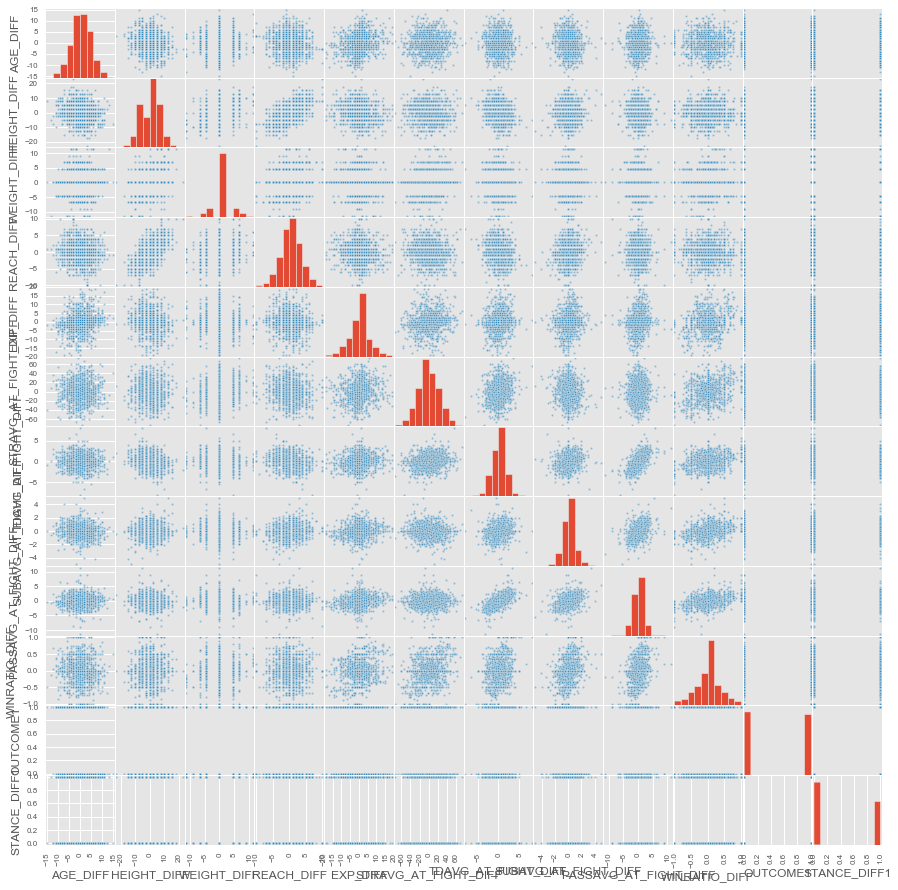

In [288]:
pd.scatter_matrix(CORRSUB, figsize=(15,15))

In [289]:
X.head(5)

,AGE_DIFF,HEIGHT_DIFF,WEIGHT_DIFF,REACH_DIFF,EXP_DIFF,STRAVG_AT_FIGHT_DIFF,TDAVG_AT_FIGHT_DIFF,SUBAVG_AT_FIGHT_DIFF,PASSAVG_AT_FIGHT_DIFF,WINRATIO_DIFF,STANCE2
6,-8,-2.54,0,-3,6,21.150000,-0.600000,0.6,-0.650000,-0.050000,0
7,8,2.54,0,3,-6,-21.150000,0.600000,-0.6,0.650000,0.050000,0
68,-1,0.00,0,3,10,18.833333,-0.333333,1.0,1.166667,-0.083333,1
69,1,0.00,0,-3,-10,-18.833333,0.333333,-1.0,-1.166667,0.083333,0
72,1,7.62,0,3,0,-19.500000,-3.000000,0.0,-2.500000,-0.500000,0


0.628252788104
[[89 49]
 [51 80]]


[('AGE_DIFF', -0.10693400005765476),
 ('HEIGHT_DIFF', -0.0055411863174606333),
 ('WEIGHT_DIFF', 0.037482827983920053),
 ('REACH_DIFF', 0.030655591288209865),
 ('EXP_DIFF', 0.011409853140007175),
 ('STRAVG_AT_FIGHT_DIFF', 0.0052914621276868284),
 ('TDAVG_AT_FIGHT_DIFF', 0.12372930136681128),
 ('SUBAVG_AT_FIGHT_DIFF', -0.14094942203002903),
 ('PASSAVG_AT_FIGHT_DIFF', 0.07656055821233014),
 ('WINRATIO_DIFF', 0.090470809239791103),
 ('STANCE2', 0.2687564119298701)]

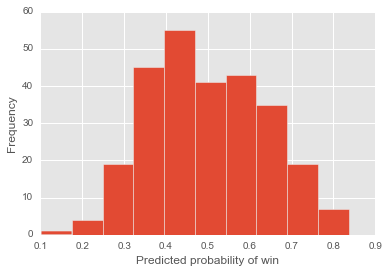

In [290]:
#fit first gen model

#Using all
#feature_cols = UFC1b[(UFC1b.WEIGHT_CLASS == CLASS)].iloc[:,[35,36,37,38,40,41,42,43,44,45,46,47,
#                                                                    48,49,50,51,52,53,54,55,56,57,61]]

#using absolute variables only
#feature_cols = UFC1b[(UFC1b.WEIGHT_CLASS == CLASS)].iloc[:,[35,36,37,38,40,41,42,43,44,45,46,47]]

#using difference variables only
#STANCE_DIFF doesn't add much value, but it makes the most sense
#feature_cols = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].iloc[:,[48,49,50,51,52,53,54,55,56,57]]
feature_cols = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].iloc[:,[48,49,50,51,52,53,54,55,56,57,66]]
#feature_cols = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].iloc[:,[48,49,50,51,52,53,54,55,56,57,62,64,65]]

X = feature_cols
y = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].OUTCOME1

#split the data into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#fit a logistic regression model and examine the coefficients
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
#zip(feature_cols, logreg.coef_[0])

#make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)
print metrics.accuracy_score(y_test, y_pred_class)

#Confusion Matrix
prds = logreg.predict(X)
print metrics.confusion_matrix(y_test, y_pred_class)

##Top Left: True Negatives 
##Top Right False Negatives 
##Bottom Left: False Negatives 
##Bottom Right: True Positives 


#predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
# plot the predicted probabilities
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(y_pred_prob)
plt.xlabel('Predicted probability of win')
plt.ylabel('Frequency')

#print the coeff
zip(feature_cols, logreg.coef_[0])

In [291]:
# convert log-odds to odds
print zip(feature_cols, np.exp(logreg.coef_[0]))

#Test case
print logreg.predict_proba([-3, 2, 2, 3, 3, 1,1,1,1, 1 ,1 ])[:, 1]
print logreg.predict_proba([+3, -2, -2, -3, -3, -1,-1,-1,-1, -1 ,0])[:, 1]

[('AGE_DIFF', 0.89858497758994715), ('HEIGHT_DIFF', 0.99447413773789461), ('WEIGHT_DIFF', 1.0381941690417889), ('REACH_DIFF', 1.0311303124619204), ('EXP_DIFF', 1.0114751937869402), ('STRAVG_AT_FIGHT_DIFF', 1.0053054866392235), ('TDAVG_AT_FIGHT_DIFF', 1.1317094773221934), ('SUBAVG_AT_FIGHT_DIFF', 0.86853323923486847), ('PASSAVG_AT_FIGHT_DIFF', 1.0795675650394863), ('WINRATIO_DIFF', 1.0946895523550233), ('STANCE2', 1.3083364070876646)]
[ 0.70046456]
[ 0.32055683]


/Users/LouisTsang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/LouisTsang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [292]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.62962963  0.56481481  0.68518519  0.60185185  0.57943925  0.68224299
  0.61682243  0.45794393  0.68224299  0.51401869]
0.601419176186
